<a href="https://colab.research.google.com/github/khushiduggar/Network-Intruison-Detection-System-using-Machine-Learning/blob/main/Network_Intrusion_Detection_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'network-intrusion-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F62266%2F120152%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240903%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240903T060536Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc5bbe8b710019fcc09ae559f7951c7de4aa973d56b60ad50791a21bbc908547d9a0369434ac0a375e9301f56f3e740aedd72f0ddf1f9e5fbb052e31f99d74e73d7221a2c3d76bcb77210c11de4f9c0a83053643bbe9b337d32c857f610e8ad0769376b9ae1e4f8464c5b86dcc7e81d3df3ab63d39df6bfc13a035d0072263e49a9ed482a1b5803ba69ea1980f27e1862a19fa9b5c431d5e22f48461c93af9240dcc1b3e7cc8a6b8c1f21052b5daf66a422d139051541ada9789927ef1c20aee76672aa8c1afc7a75e1aaf5d4a66659f4714120dcc1072aeeef5d8c30945c437df60753d4b1b55622987044dc5fc10d80e6adb2e40d334b35270757c535f8f329'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 838086 bytes downloaded
Downloaded and uncompressed: network-intrusion-detection
Data source import complete.


In [ ]:

import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/network-intrusion-detection/Train_data.csv
/kaggle/input/network-intrusion-detection/Test_data.csv


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import RFE
import itertools
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Reading the Training Dataset

In [ ]:
train = pd.read_csv("/kaggle/input/network-intrusion-detection/Train_data.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
train.shape

(25192, 42)

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.describe(include='object')

,protocol_type,service,flag,class
count,25192,25192,25192,25192
unique,3,66,11,2
top,tcp,http,SF,normal
freq,20526,8003,14973,13449


# Exploratory Data Analysis(EDA)

In [ ]:
train['class'].value_counts()

,count
class,
normal,13449
anomaly,11743


<Axes: xlabel='class', ylabel='count'>

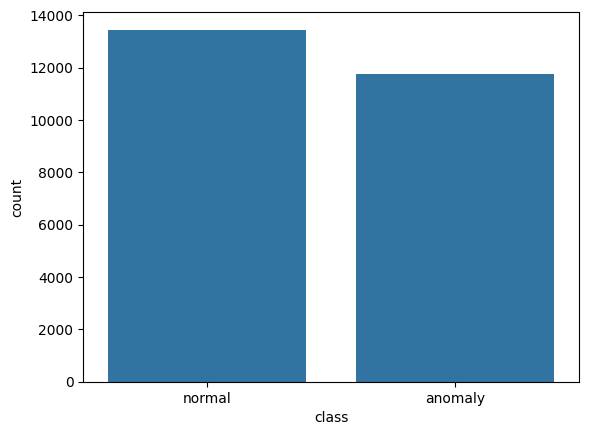

In [ ]:
sns.countplot(x=train['class'])

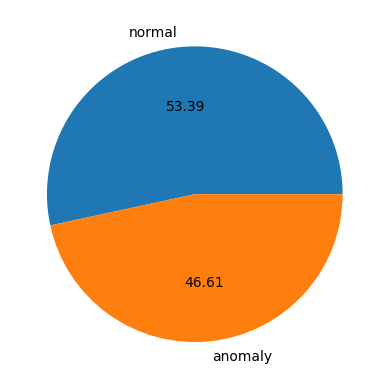

In [ ]:
plt.pie(train['class'].value_counts(),labels=['normal','anomaly'],autopct="%0.2f")
plt.show()

In [ ]:
train['protocol_type'].value_counts()

,count
protocol_type,
tcp,20526
udp,3011
icmp,1655


<Axes: xlabel='protocol_type', ylabel='count'>

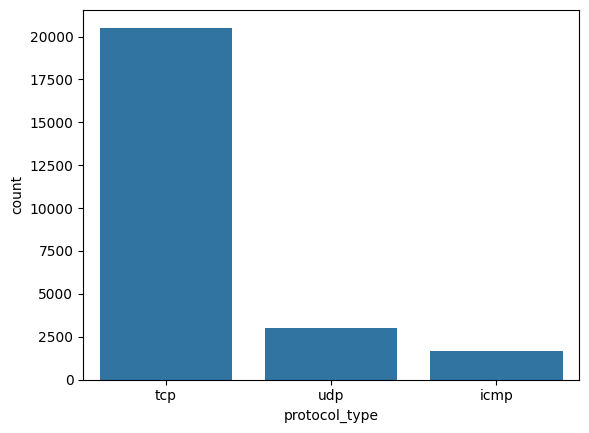

In [ ]:
sns.countplot(x=train['protocol_type'])

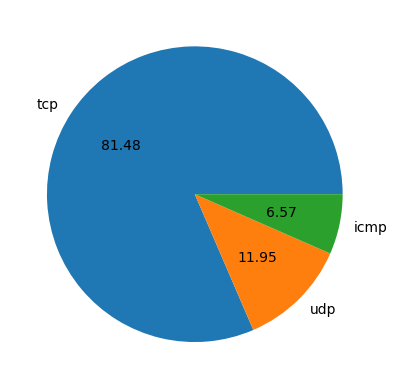

In [ ]:
plt.pie(train['protocol_type'].value_counts(),labels=['tcp','udp','icmp'],autopct="%0.2f")
plt.show()

<Axes: >

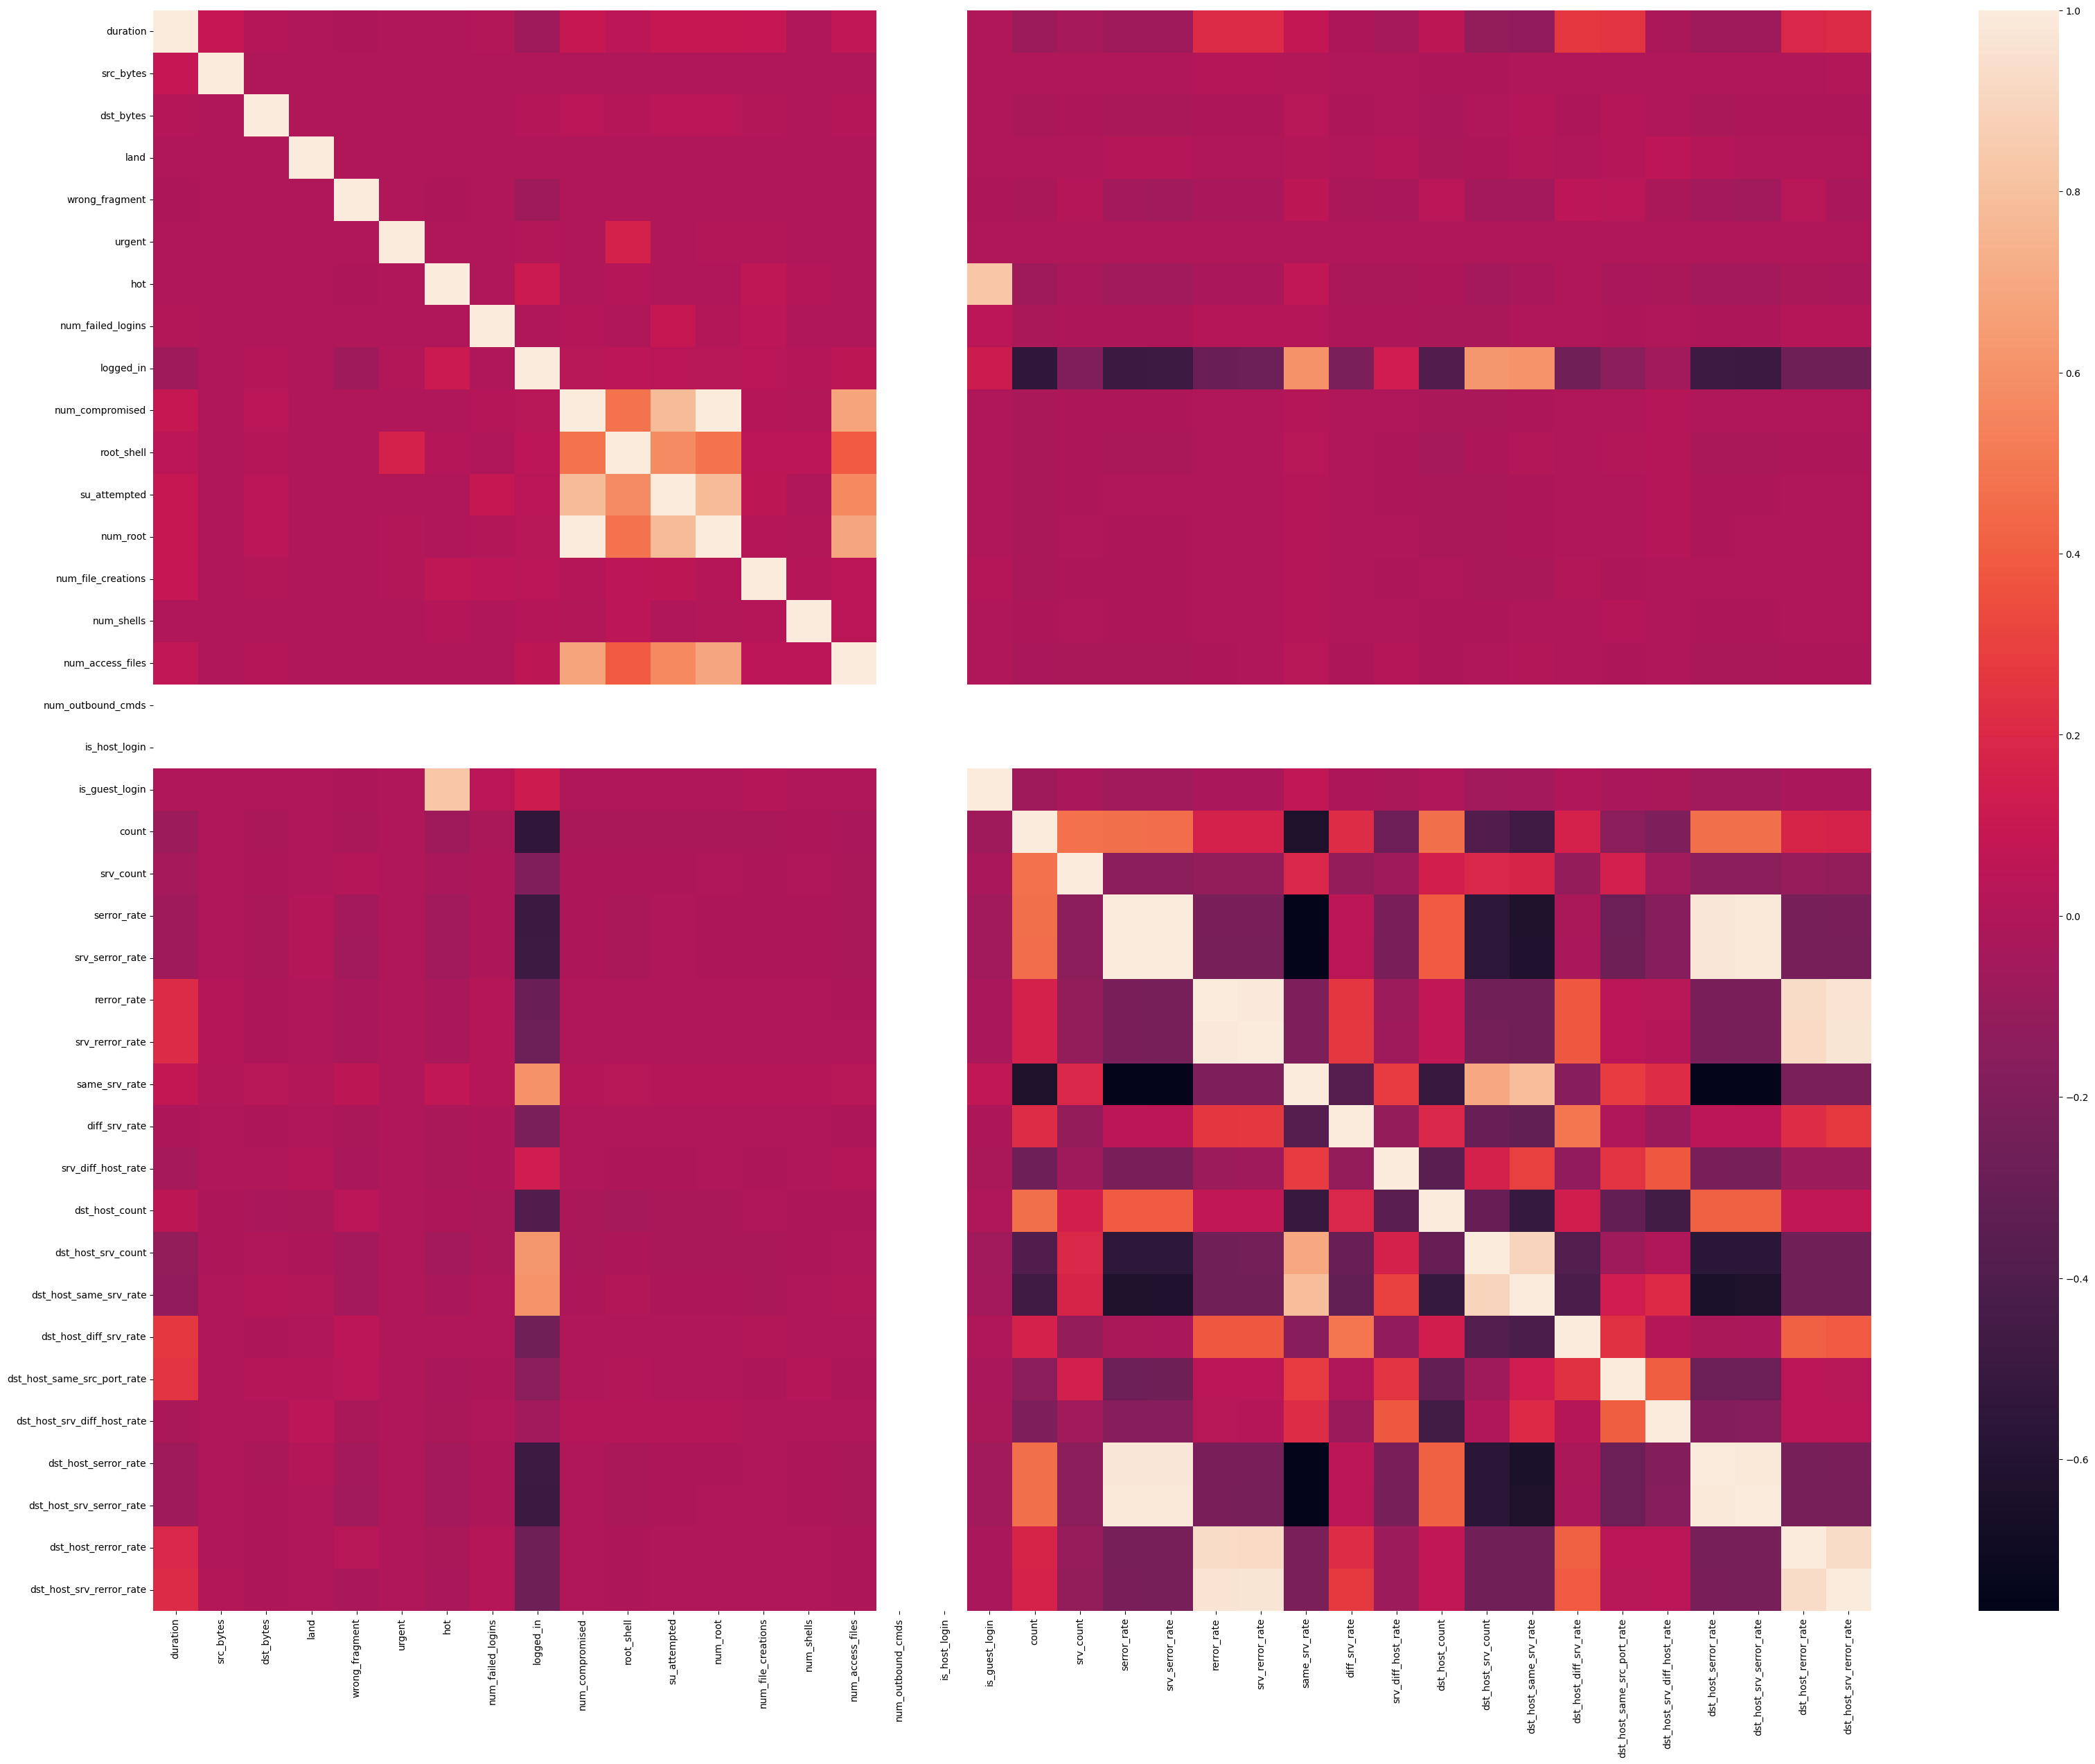

In [ ]:
plt.figure(figsize=(40,30))
sns.heatmap(train.corr(numeric_only = True))

# Data Preprocessing

- Missing Values
- Duplicates
- Encoding
- Scaling
- Features Selection
- Dataset Splitting

## Missing Values

In [ ]:
train.isnull().sum()

,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


## Duplicates

In [ ]:
print(f"Number of duplicates: {train.duplicated().sum()}")

Number of duplicates: 0


In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


## Label Encoding

In [ ]:
label_encoder = LabelEncoder()
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                df[col] = label_encoder.fit_transform(df[col])

le(train)

In [ ]:
train

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,1,16,2,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,0
25188,0,1,19,9,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,0
25189,0,1,46,1,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,0
25190,0,1,38,5,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,0


## Features Selection

In [ ]:
train['num_outbound_cmds']

,num_outbound_cmds
0,0
1,0
2,0
3,0
4,0
...,...
25187,0
25188,0
25189,0
25190,0


In [ ]:
#Drop the redundant feature
train.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [ ]:

X = train.drop(['class'], axis=1)
y = train['class']
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X, y)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
selected_features = [v for i, v in feature_map if i==True]
top_features = pd.DataFrame({'Features': selected_features})
top_features.index = top_features.index + 1


In [ ]:
top_features

,Features
1,protocol_type
2,service
3,flag
4,src_bytes
5,dst_bytes
6,count
7,same_srv_rate
8,diff_srv_rate
9,dst_host_srv_count
10,dst_host_same_srv_rate


## Standard Scaler

In [ ]:
X = X[selected_features]
scale = StandardScaler()
X = scale.fit_transform(X)

## Dataset Splitting

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.80,random_state=2)

# Model Selection

## Support Vector Machine

=============================== Support Vector Machine ==============================
Accuracy:  0.9769795594363961
Precision:  0.9712518195050946
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2333
           1       0.97      0.99      0.98      2706

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



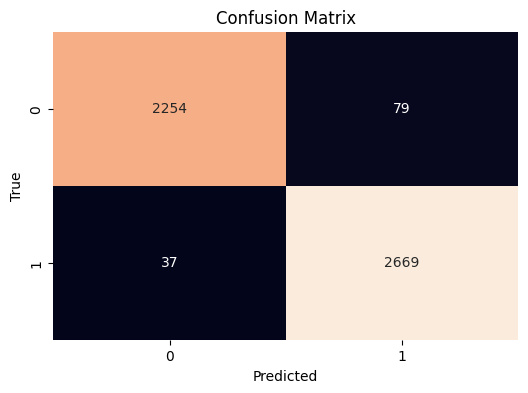

In [ ]:
svc = SVC(kernel='poly', gamma=1.0)
svc.fit(X_train,y_train)
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('=============================== Support Vector Machine ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Confusion Matrix")
plt.show()

## K-Nearest Neighbors Classifier

============================== K-Neighbors Classifier ==============================
Accuracy:  0.9833300257987696
Precision:  0.9844789356984479
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2333
           1       0.98      0.98      0.98      2706

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



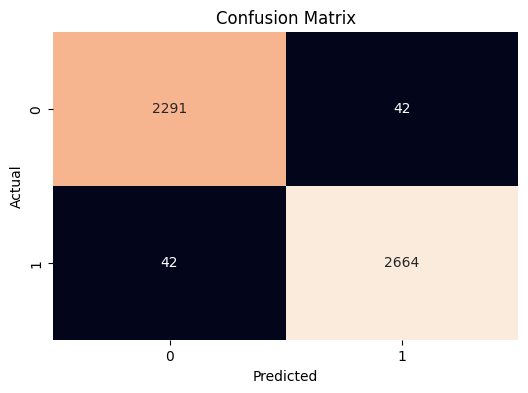

In [ ]:
knc = KNeighborsClassifier()
knc.fit(X_train,y_train)
y_pred = knc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== K-Neighbors Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Naive-Bayes Classifier

============================== Naive-Bayes Classifier ==============================
Accuracy:  0.8920420718396507
Precision:  0.8656968876860622
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88      2333
           1       0.87      0.95      0.90      2706

    accuracy                           0.89      5039
   macro avg       0.90      0.89      0.89      5039
weighted avg       0.90      0.89      0.89      5039



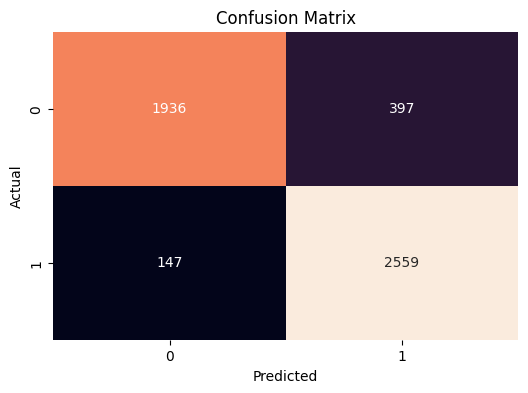

In [ ]:
# gnb = GaussianNB()
# mnb = MultinomialNB()
bnb = BernoulliNB()

bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Naive-Bayes Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Decision-Tree Classifier

============================== Decision-Tree Classifier ==============================
Accuracy:  0.9966263147449891
Precision:  0.9985168705969596
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



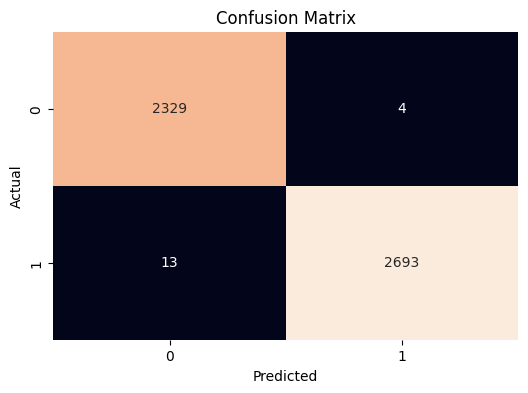

In [ ]:
dtc = DecisionTreeClassifier(max_depth=15,criterion='entropy')
dtc.fit(X_train,y_train)
y_pred = dtc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Decision-Tree Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Logistic Regression

============================== Logistic Regression ==============================
Accuracy:  0.9196269101012106
Precision:  0.9069685178634594
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.89      0.91      2333
           1       0.91      0.95      0.93      2706

    accuracy                           0.92      5039
   macro avg       0.92      0.92      0.92      5039
weighted avg       0.92      0.92      0.92      5039



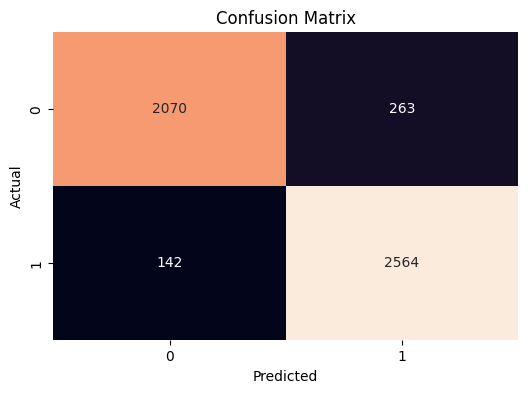

In [ ]:
lrc = LogisticRegression()
lrc.fit(X_train,y_train)
y_pred = lrc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Logistic Regression ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Random Forest Classifier

============================== Random Forest Classifier ==============================
Accuracy:  0.9964278626711649
Precision:  0.9977777777777778
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



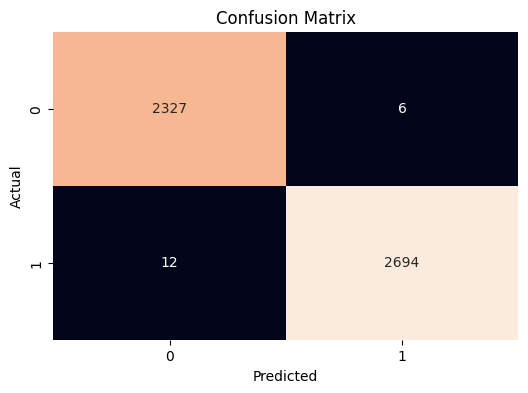

In [ ]:
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Random Forest Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Ada Boost Classifier

============================== Ada Boost Classifier ==============================
Accuracy:  0.9813455050605279
Precision:  0.9787390029325513
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2333
           1       0.98      0.99      0.98      2706

    accuracy                           0.98      5039
   macro avg       0.98      0.98      0.98      5039
weighted avg       0.98      0.98      0.98      5039



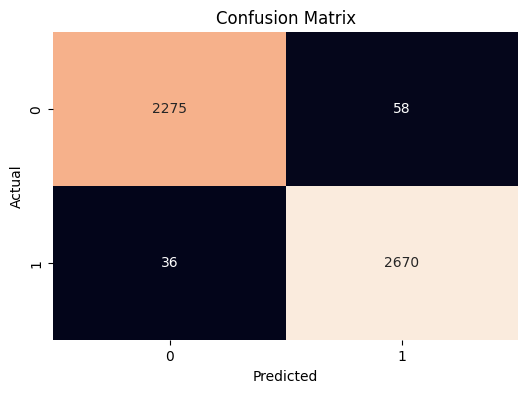

In [ ]:
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
abc.fit(X_train,y_train)
y_pred = abc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Ada Boost Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Bagging Classifier

============================== Bagging Classifier ==============================
Accuracy:  0.9962294105973407
Precision:  0.9977769544275658
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



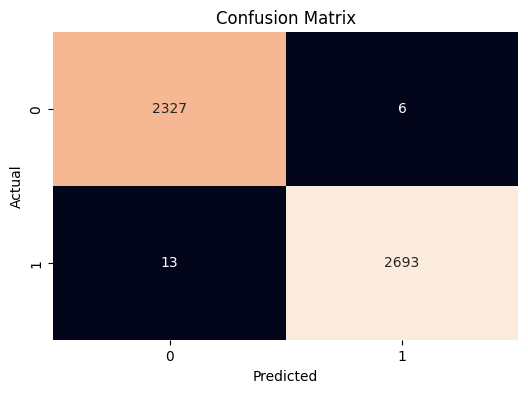

In [ ]:
bc = BaggingClassifier(n_estimators=50, random_state=2)
bc.fit(X_train,y_train)
y_pred = bc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Bagging Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## Extra Trees Classifier

============================== Extra Trees Classifier ==============================
Accuracy:  0.9970232188926375
Precision:  0.9974121996303142
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



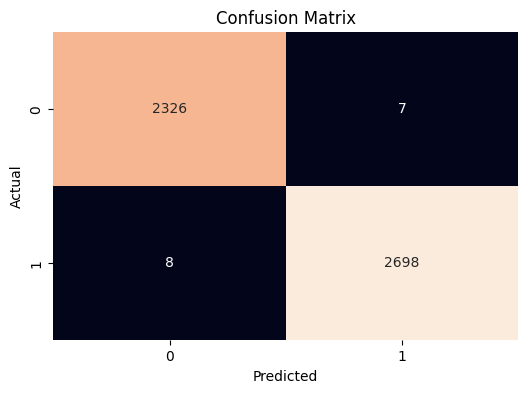

In [ ]:
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
etc.fit(X_train,y_train)
y_pred = etc.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Extra Trees Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

## XGB Classifier

============================== Gradient Boosting Classifier ==============================
Accuracy:  0.9958325064496923
Precision:  0.9966703662597114
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2333
           1       1.00      1.00      1.00      2706

    accuracy                           1.00      5039
   macro avg       1.00      1.00      1.00      5039
weighted avg       1.00      1.00      1.00      5039



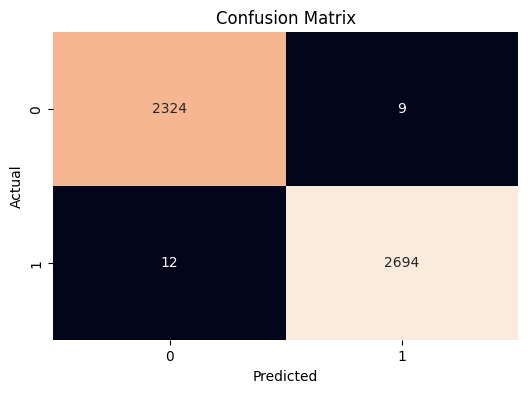

In [ ]:
xgb = XGBClassifier(n_estimators=50,random_state=2)
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('============================== Gradient Boosting Classifier ==============================')
print("Accuracy: ", accuracy_score(y_test,y_pred))
print("Precision: ", precision_score(y_test,y_pred))
print("Classification Report:\n", report)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

# Evaluation Metrics

In [ ]:
clfs = {
    'SVC' : svc,
    'KN' : knc,
    'NB': bnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'xgb':xgb
}

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

def metrics(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    return accuracy, precision, f1, recall

In [ ]:
accuracy_scores = []
precision_scores = []
f1_scores = []
recall_scores = []

for name, clf in clfs.items():
    current_accuracy, current_precision, current_f1, current_recall = metrics(clf, X_train, y_train, X_test, y_test)
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)
    f1_scores.append(current_f1)
    recall_scores.append(current_recall)

# Comparing Performance of Different Machine Learning Algorithms

In [ ]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores,'F1-score':f1_scores,'Recall':recall_scores}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
performance_df.index = performance_df.index + 1

In [ ]:
performance_df

,Algorithm,Accuracy,Precision,F1-score,Recall
1,ETC,0.997023,0.997023,0.997023,0.997023
2,DT,0.996428,0.996437,0.996428,0.996428
3,RF,0.996428,0.996431,0.996428,0.996428
4,BgC,0.996229,0.996234,0.996230,0.996229
5,xgb,0.995833,0.995834,0.995833,0.995833
6,KN,0.983330,0.983330,0.983330,0.983330
7,AdaBoost,0.981346,0.981370,0.981339,0.981346
8,SVC,0.976980,0.977085,0.976964,0.976980
9,LR,0.919627,0.920319,0.919436,0.919627
10,NB,0.892042,0.895204,0.891370,0.892042


## Accuracy Scores of Different Machine Learning Algorithms

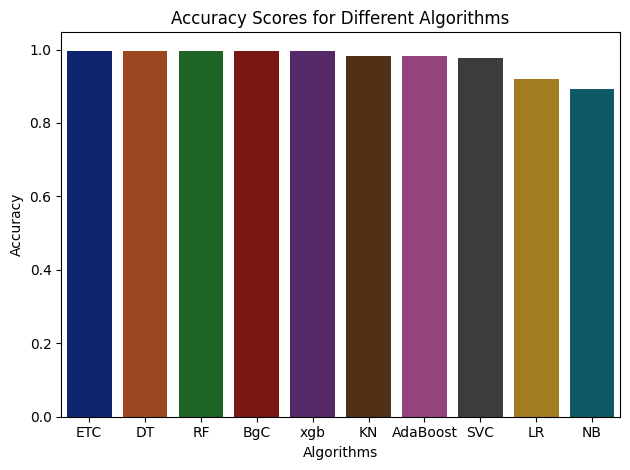

In [ ]:
sns.barplot(performance_df, x='Algorithm', y='Accuracy',palette='dark')
plt.xlabel('Algorithms')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Algorithms')
plt.tight_layout()
plt.show()

## Precision Scores of Different Machine Learning Algorithms

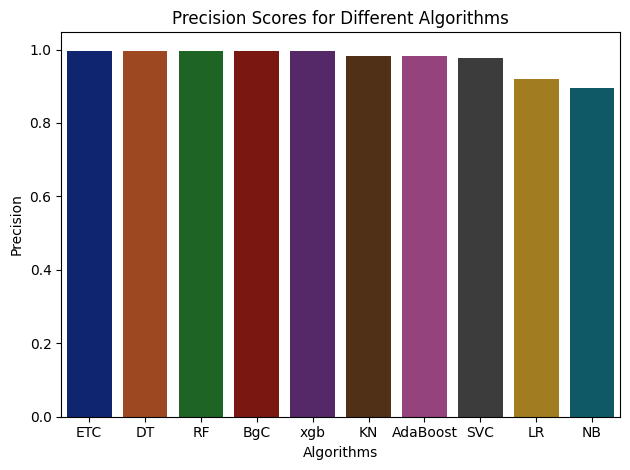

In [ ]:
sns.barplot(performance_df, x='Algorithm', y='Precision',palette='dark')
plt.xlabel('Algorithms')
plt.ylabel('Precision')
plt.title('Precision Scores for Different Algorithms')
plt.tight_layout()
plt.show()


## F1 Scores of Different Machine Learning Algorithms

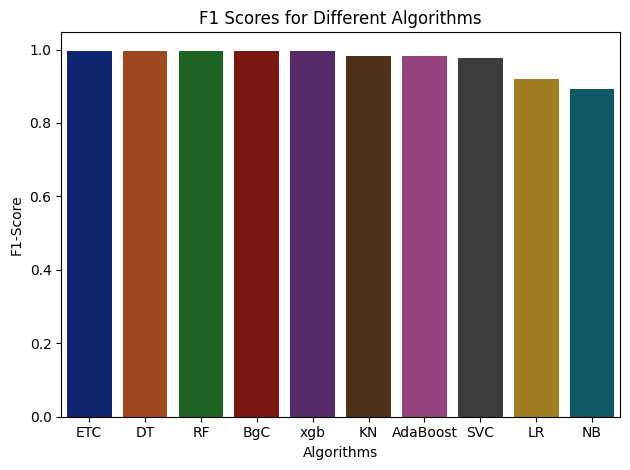

In [ ]:
sns.barplot(performance_df, x='Algorithm', y='F1-score',palette='dark')
plt.xlabel('Algorithms')
plt.ylabel('F1-Score')
plt.title('F1 Scores for Different Algorithms')
plt.tight_layout()
plt.show()


## Recall Scores of Different Machine Learning Algorithms

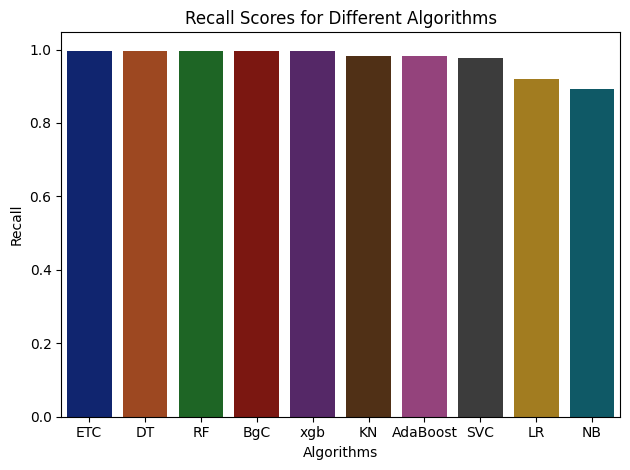

In [ ]:
sns.barplot(performance_df, x='Algorithm', y='Recall',palette='dark')
plt.xlabel('Algorithms')
plt.ylabel('Recall')
plt.title('Recall Scores for Different Algorithms')
plt.tight_layout()
plt.show()

# Prediction For Test Dataset

## Reading the Testing Dataset

In [ ]:
test = pd.read_csv("/kaggle/input/network-intrusion-detection/Test_data.csv")

## Exploratory Data Analysis(EDA)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  int64  
 5   dst_bytes                    22544 non-null  int64  
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [ ]:
test.shape

(22544, 41)

In [ ]:
test.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71


In [ ]:
test.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22544.000000,2.254400e+04,2.254400e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,218.859076,1.039545e+04,2.056019e+03,0.000311,0.008428,0.000710,0.105394,0.021647,0.442202,0.119899,...,193.869411,140.750532,0.608722,0.090540,0.132261,0.019638,0.097814,0.099426,0.233385,0.226683
std,1407.176612,4.727864e+05,2.121930e+04,0.017619,0.142599,0.036473,0.928428,0.150328,0.496659,7.269597,...,94.035663,111.783972,0.435688,0.220717,0.306268,0.085394,0.273139,0.281866,0.387229,0.400875
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
test['num_outbound_cmds']

,num_outbound_cmds
0,0
1,0
2,0
3,0
4,0
...,...
22539,0
22540,0
22541,0
22542,0


In [ ]:
#Drop the redundant feature
test.drop(['num_outbound_cmds'], axis=1, inplace=True)

## Missing Values

In [ ]:
test.isnull().sum()

,0
duration,0
protocol_type,0
service,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


## Duplicates

In [ ]:
print(f"Number of duplicates: {test.duplicated().sum()}")

Number of duplicates: 57


In [ ]:
test.drop_duplicates(inplace=True)

In [ ]:
test.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22487.000000,2.248700e+04,2.248700e+04,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,...,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000,22487.000000
mean,219.413839,1.042155e+04,2.060921e+03,0.000311,0.008449,0.000712,0.105661,0.021701,0.443323,0.120203,...,193.720861,140.504380,0.607873,0.090617,0.132586,0.019688,0.098056,0.099678,0.233848,0.227124
std,1408.915818,4.733850e+05,2.124595e+04,0.017641,0.142779,0.036519,0.929589,0.150514,0.496788,7.278803,...,94.103599,111.779078,0.435770,0.220709,0.306588,0.085496,0.273442,0.282179,0.387459,0.401129
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,120.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,166.000000,0.920000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.080000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
test.describe(include='object')

,protocol_type,service,flag
count,22487,22487,22487
unique,3,64,11
top,tcp,http,SF
freq,18877,7853,14821


## Label Encoding

In [ ]:
test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,private,REJ,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00
1,0,tcp,private,REJ,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,tcp,smtp,SF,794,333,0,0,0,0,...,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00
22540,0,tcp,http,SF,317,938,0,0,0,0,...,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00
22541,0,tcp,http,SF,54540,8314,0,0,0,2,...,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07
22542,0,udp,domain_u,SF,42,42,0,0,0,0,...,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00


In [ ]:
le(test)

In [ ]:
test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,1,45,1,0,0,0,0,0,0,...,255,10,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00
1,0,1,45,1,0,0,0,0,0,0,...,255,1,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00
2,2,1,19,9,12983,0,0,0,0,0,...,134,86,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00
3,0,0,13,9,20,0,0,0,0,0,...,3,57,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00
4,1,1,55,2,0,15,0,0,0,0,...,29,86,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22539,0,1,49,9,794,333,0,0,0,0,...,100,141,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00
22540,0,1,22,9,317,938,0,0,0,0,...,197,255,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00
22541,0,1,22,9,54540,8314,0,0,0,2,...,255,255,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07
22542,0,2,11,9,42,42,0,0,0,0,...,255,252,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00


## Feature Selection


In [ ]:
X = test[selected_features]
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

## Prediction of Test Data

In [ ]:
# Decision Tree is better model due to less false positives
dtc.predict(X_scaled)

array([0, 0, 1, ..., 1, 0, 1])